# Proyecto: Impacto del Riego en la Productividad Agrícola en México
Este notebook contiene el flujo ETL base para preparar los datos.

## Exploracion del conjunto de datos de agricultura

In [40]:
import os
import requests
import zipfile
from io import BytesIO
import shutil

def download_and_extract_zip(zip_url: str, extract_to: str = "data") -> str:
    """
    Downloads a ZIP file from the given URL and extracts all contents.
    Returns the path where files were extracted.
    """
    os.makedirs(extract_to, exist_ok=True)
    print(f"⬇️  Downloading ZIP file from: {zip_url}")

    # Stream download for large files
    response = requests.get(zip_url, stream=True)
    response.raise_for_status()

    # Extract directly from memory (no need to save locally)
    with zipfile.ZipFile(BytesIO(response.content)) as zf:
        zf.extractall(extract_to)

    print(f"✅ Files extracted to: {extract_to}")
    return extract_to


def collect_csv_files(root_folder: str, destination_folder: str = "csv_files") -> None:
    """
    Recursively finds all CSV files in `root_folder` and copies them
    to `destination_folder` for easier access.
    """
    os.makedirs(destination_folder, exist_ok=True)
    count = 0

    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower().endswith(".csv"):
                src_path = os.path.join(dirpath, file)
                dest_path = os.path.join(destination_folder, file)
                shutil.copy2(src_path, dest_path)
                count += 1
                print(f"📄 Copied: {file}")

    print(f"\n✅ {count} CSV files copied to '{destination_folder}'.")


# 🔧 Example usage (run this after defining the functions)
zip_url = "https://www.inegi.org.mx/contenidos/programas/ca/2022/datosabiertos/ca_2022_upagro_csv.zip"

# 1️⃣ Download and extract
extracted_path = download_and_extract_zip(zip_url, extract_to="downloaded_data")

# 2️⃣ Gather all CSV files in one place
collect_csv_files(extracted_path, destination_folder="all_csvs")

⬇️  Downloading ZIP file from: https://www.inegi.org.mx/contenidos/programas/ca/2022/datosabiertos/ca_2022_upagro_csv.zip
✅ Files extracted to: downloaded_data
📄 Copied: ca2022_gan33.csv
📄 Copied: ca2022_gan59.csv
📄 Copied: ca2022_05.csv
📄 Copied: indice_agro.csv
📄 Copied: ca2022_11.csv
📄 Copied: ca2022_agr10b.csv
📄 Copied: ca2022_gan06.csv
📄 Copied: ca2022_maq04.csv
📄 Copied: ca2022_gan68.csv
📄 Copied: ca2022_soc02.csv
📄 Copied: ca2022_12.csv
📄 Copied: ca2022_agr10.csv
📄 Copied: ca2022_agr05.csv
📄 Copied: ca2022_agr28.csv
📄 Copied: ca2022_gan45.csv
📄 Copied: ca2022_gan46.csv
📄 Copied: ca2022_gan60.csv
📄 Copied: ca2022_agr04.csv
📄 Copied: ca2022_06.csv
📄 Copied: ca2022_gan07.csv
📄 Copied: ca2022_prob01.csv
📄 Copied: ca2022_gan15.csv
📄 Copied: ca2022_gan08.csv
📄 Copied: ca2022_gan03.csv
📄 Copied: ca2022_gan02.csv
📄 Copied: ca2022_04.csv
📄 Copied: ca2022_10.csv
📄 Copied: ca2022_maq01.csv
📄 Copied: ca2022_gan41.csv
📄 Copied: ca2022_gan35.csv
📄 Copied: ca2022_gan27.csv
📄 Copied: ca2022_gan

In [41]:
data_path = './all_csvs'
files = os.listdir(data_path)
files

['ca2022_gan33.csv',
 'ca2022_gan59.csv',
 'ca2022_05.csv',
 'indice_agro.csv',
 'ca2022_11.csv',
 'ca2022_agr10b.csv',
 'ca2022_gan06.csv',
 'ca2022_maq04.csv',
 'ca2022_gan68.csv',
 'ca2022_soc02.csv',
 'ca2022_12.csv',
 'ca2022_agr10.csv',
 'ca2022_agr05.csv',
 'ca2022_agr28.csv',
 'ca2022_gan45.csv',
 'ca2022_gan46.csv',
 'ca2022_gan60.csv',
 'diccionario_de_datos_CA2022_upagro.csv',
 'ca2022_agr04.csv',
 'ca2022_06.csv',
 'ca2022_gan07.csv',
 'ca2022_prob01.csv',
 'ca2022_gan15.csv',
 'ca2022_gan08.csv',
 'ca2022_gan03.csv',
 'ca2022_gan02.csv',
 'ca2022_04.csv',
 'ca2022_10.csv',
 'ca2022_maq01.csv',
 'ca2022_gan41.csv',
 'ca2022_gan35.csv',
 'ca2022_gan27.csv',
 'ca2022_gan67.csv',
 'ca2022_gan44.csv',
 'ca2022_gan26.csv',
 'ca2022_08.csv',
 'ca2022_gan04.csv',
 'ca2022_gan63.csv',
 'ca2022_amb01.csv',
 'ca2022_09.csv',
 'ca2022_soc05.csv',
 'ca2022_mo01.csv',
 'ca2022_cred01.csv',
 'ca2022_soc01.csv',
 'ca2022_agr07.csv',
 'ca2022_gan52.csv',
 'ca2022_soc04.csv',
 'ca2022_agr11

In [47]:
df = pd.read_csv('./all_csvs/diccionario_de_datos_CA2022_upagro.csv')

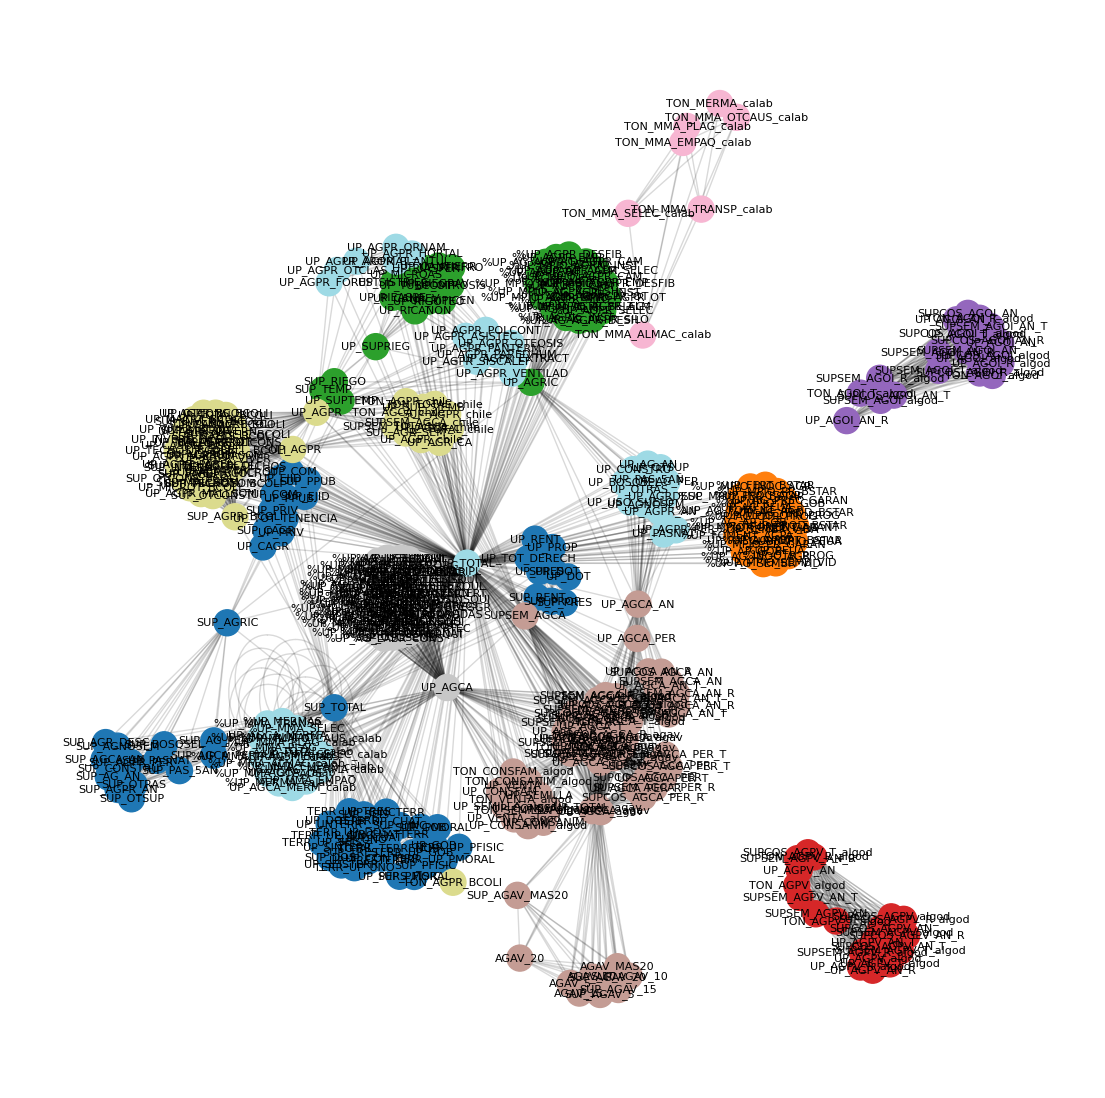

In [108]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

# df_map with: dataset | variable

# 1. Build co-occurrence graph
grouped = df.groupby("TABULADO")["DESCRIPCION"].apply(list)
G = nx.Graph()

for vars_list in grouped:
    for i in range(len(vars_list)):
        for j in range(i + 1, len(vars_list)):
            G.add_edge(vars_list[i], vars_list[j])

# 2. Detect communities (clusters)
communities = community.louvain_communities(G, seed=42)

# 3. Assign a cluster id to each node
cluster_map = {}
for cluster_id, nodes in enumerate(communities):
    for n in nodes:
        cluster_map[n] = cluster_id

# 4. Plot the color-coded cluster graph
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, k=0.25)

# Colors per cluster
colors = [cluster_map[n] for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=350, node_color=colors, cmap="tab20")
nx.draw_networkx_edges(G, pos, alpha=0.15)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis("off")
plt.show()


In [122]:
variables = df.assign(value=1).pivot_table(index="TABULADO",columns="DESCRIPCION",values="value",aggfunc="max",fill_value=0).astype(int).sum().sort_values(ascending=False)
top_variables = variables[variables > 2].reset_index()['DESCRIPCION'].to_list()
top_variables

['UP_TOTAL',
 'SUP_TOTAL',
 'UP_AGCA',
 'UP_AGPR',
 'UP_AGRIC',
 'UP_TOTAL_agav',
 'SUPSEM_AGCA_agav',
 'TON_AGCA_algod',
 'UP_AGCA_algod',
 'UP_TOTAL_algod',
 'UP_AGCA_agav']

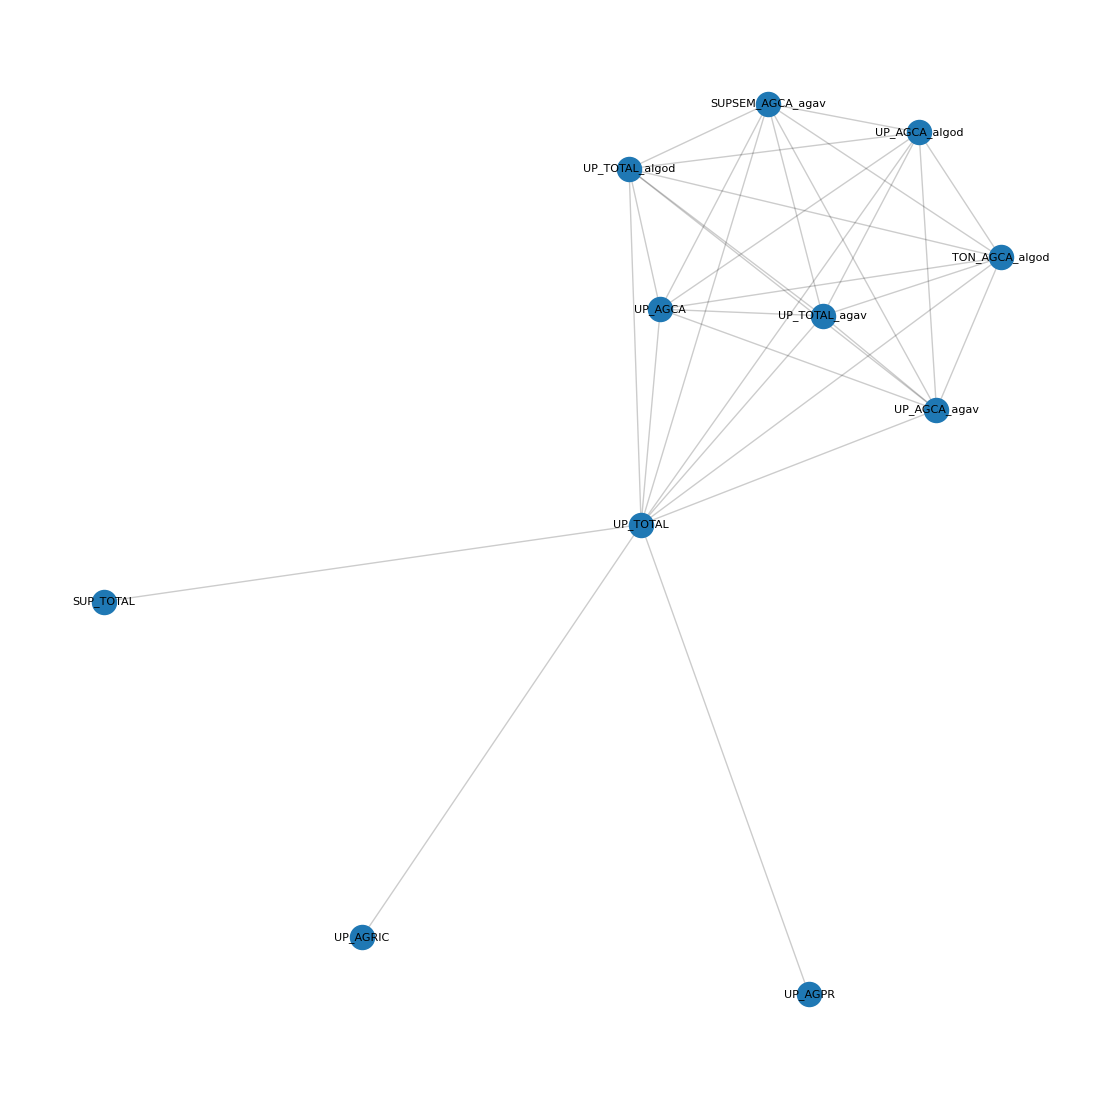

In [113]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# df_map has: dataset, variable
# Example:
# dataset | variable
#   A     | SUP_RIEGO
#   A     | SUP_TEMP
#   A     | UP_SUPRIEG
#   B     | SUP_RIEGO
#   B     | UP_RIGOTEO

# 1. Group variables by dataset
grouped = df[df['DESCRIPCION'].isin(top_variables)].groupby("TABULADO")["DESCRIPCION"].apply(list)

# 2. Create a graph
G = nx.Graph()

# 3. Add edges between all variable pairs that co-occur in a dataset
for vars_list in grouped:
    for i in range(len(vars_list)):
        for j in range(i + 1, len(vars_list)):
            var1, var2 = vars_list[i], vars_list[j]
            G.add_edge(var1, var2)

# 4. Draw
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, k=0.25)  # layout for clearer separation

nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis("off")
plt.show()


<Axes: xlabel='TABULADO', ylabel='DESCRIPCION'>

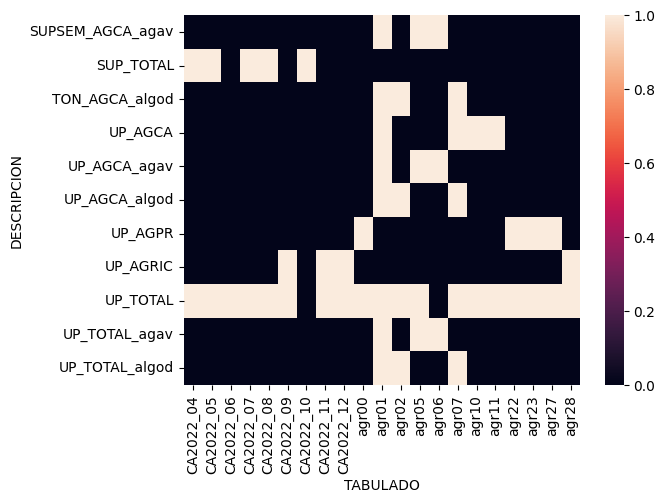

In [114]:
import seaborn as sns
sns.heatmap(df[df['DESCRIPCION'].isin(top_variables)].assign(value=1).pivot_table(index="DESCRIPCION",columns="TABULADO",values="value",aggfunc="max",fill_value=0).astype(int))

## Funciones ETL

In [42]:
def load_dataset(path):
    return pd.read_csv(path, encoding='utf-8', low_memory=False)

def clean_columns(df):
    df.columns = (
        df.columns
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('[^a-z0-9_]', '', regex=True)
    )
    return df

def add_variables(df, surface_col='superficie', production_col='produccion'):
    if surface_col in df.columns and production_col in df.columns:
        df['rendimiento'] = df[production_col] / df[surface_col].replace(0, np.nan)
    return df

## Pipeline ejemplo (placeholders)

In [43]:
example_file = 0
for f in files:
    if f.endswith('.csv'):
        example_file = os.path.join(data_path, f)
        if example_file:
          print(example_file)
          df = load_dataset(example_file)
          df = clean_columns(df)
          #df = add_variables(df)
          print(df.head())
        else:
            'No CSV files found to demonstrate ETL.'


./all_csvs/ca2022_gan33.csv
   cve_ent  cve_mun ent_abr         nom_mun                   ent_fed  \
0        0        0  00 NAL             NaN  ESTADOS UNIDOS MEXICANOS   
1        1        0  01 AGS             NaN            Aguascalientes   
2        1        1  01 AGS  Aguascalientes            Aguascalientes   
3        1        2  01 AGS        Asientos                  Asientos   
4        1        3  01 AGS        Calvillo                  Calvillo   

    up_total  up_ganado  up_porcino  pr_up_pc_tincl  pr_up_pc_mezc  \
0  4629134.0  2458952.0      582727        6.732312      11.332875   
1    19648.0    10273.0        1895       24.379947      14.935065   
2     3098.0     1817.0         365       36.164384      19.696970   
3     3302.0     1663.0         333       16.816817      16.071429   
4     2659.0     1402.0         131       29.770992       5.128205   

   pr_up_pc_nave  pr_up_pc_basc  pr_up_pc_cam  pr_up_pc_pconcr  \
0       9.905432      12.808748      1.185287 

In [ ]:
df.describe()

,inegi_censo_agropecuario_2022,unnamed_1,unnamed_2,unnamed_3,unnamed_4,unnamed_5,unnamed_6,unnamed_7,unnamed_8,unnamed_9,cuadro_ca2022_02
count,38,36,36,35,36,36,35,36,35,35,35
unique,38,36,36,35,36,36,35,36,35,35,35
top,Superficie total y de uso agropecuario y fores...,Superficie del país,Superficie con uso o vocación agropecuaria y a...,Cubierta por el censo,Superficie declarada de las unidades de produc...,Uso agrícola,Sembrada u ocupada con cultivos,No sembrada,En descanso,"Agostadero, pastos naturales, enmontada, bosqu...",Con otros usos
freq,1,1,1,1,1,1,1,1,1,1,1
